In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
from scipy.linalg import polar as pf
from scipy.linalg import expm, logm
import random

## Create data

Create an element of St(2, 3), 2-dimensional orthonormal frame in $\mathbb{R}^3$

In [2]:
Frame = np.array([[1, 0, 0], [0, 1, 0]]).T
Frame.shape

(3, 2)

Create $N$ elements of SO(3), special orhogonal group of rotation matrices, to rotate St(2, 3) along Z-axis by $N$ degrees by each rotation matrix

In [3]:
N = 61
SO1 = np.zeros((N, 3, 3))

for i, phi in enumerate(range(0, N)):
    phi = (phi + 1) / 360 * 2 * np.pi
    SO1[i] = np.array([
        [np.cos(phi), -np.sin(phi), 0],
        [np.sin(phi), np.cos(phi), 0],
        [0, 0, 1]
    ])

In [4]:
N = 61
SO2 = np.zeros((N, 3, 3))

for i, phi in enumerate(range(0, N)):
    phi = (phi + 1) / 360 * 2 * np.pi
    SO2[i] = np.array([
        [1, 0, 0],
        [0, np.cos(phi), -np.sin(phi)],
        [0, np.sin(phi), np.cos(phi)],
        
    ])

Create $N$ elements of St(2, 3) by applying rotation transforms

In [24]:
Frame_rot = np.zeros((N, Frame.shape[0], Frame.shape[1]))

for i, so in enumerate(SO1):
    Frame_rot[i] = SO2[i].dot(SO1[i].dot(Frame))
    
sought_for_mean_idx = int(Frame_rot.shape[0] / 2)
    
Frame_rot.shape

(61, 3, 2)

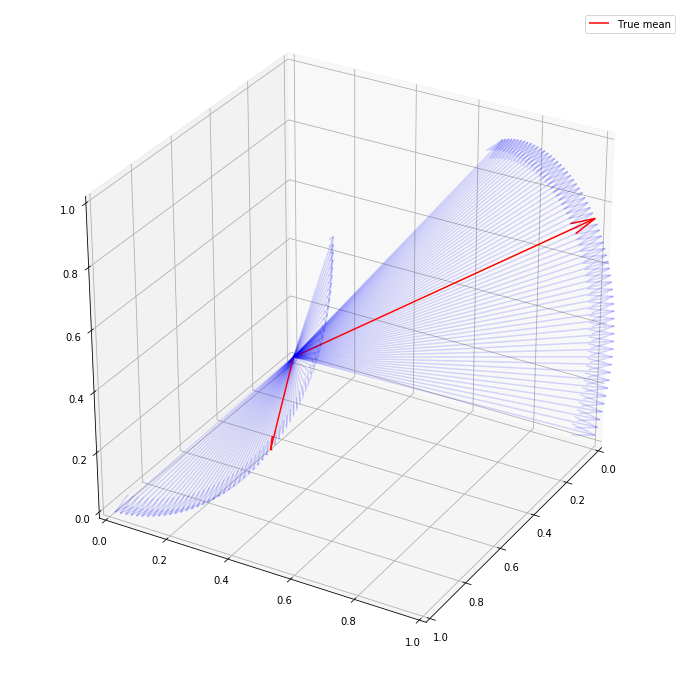

In [26]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

origin = [0,0,0]

for i, frame_rot in enumerate(Frame_rot):
    X, Y, Z = zip(origin, origin) 
    U, V, W = zip(frame_rot.T[0], frame_rot.T[1])
    c = "blue"
    alpha = 0.15
    label = None
    if i == sought_for_mean_idx:
        c = "red"
        alpha = 1
        label = "True mean"
    ax.quiver(X,Y,Z,U,V,W, color=c, alpha=alpha, arrow_length_ratio=0.075, label=label)

ax.set_xlim([0,1.0])
ax.set_ylim([0,1.0])
ax.set_zlim([0,1.0])
ax.view_init(30, 30)
ax.legend()

plt.show()

## Mean, exponential, logarithmic maps and principal angle distance

In [7]:
def dist(X, Y):
    _, S, _ = np.linalg.svd(X.T @ Y, full_matrices=False)
    Phi = np.arccos(S)
    return np.sqrt(np.sum(Phi ** 2))

In [10]:
def exp(V, X):
    
    n, p = X.shape
    
    P = np.matmul(X, X.T)
    K = V - np.matmul(P, V)
    Q, R = np.linalg.qr(K)
    
    MNe = expm(np.block([[np.zeros((p, p)), -R.T], [R, np.zeros((p, p))]]))
    
    return np.matmul(np.block([X, Q]), MNe[:, 0:p])

def log(X, X0):
    n, p = X0.shape
    M = X0.T @ X
    U, S, VT = np.linalg.svd((np.eye(n) - X0 @ X0.T) @ X @ np.linalg.inv(M), full_matrices=False)
    S_diag = np.diag(S)
    return U @ np.arctan(S_diag) @ VT

In [11]:
def mean(X, Qs):
    V = []
    for i, Q in enumerate(Qs):
        try:
            v = log(Q, X)
            V.append(v)
            #####print("V=", V)
        except Exception as error:
            #pass
            print("Q does not belong to the domain of the lifting map P_X^{-1}, because of", error)
            
    if len(V) <=0:
        raise Exception("V is empty")
            
    V = np.array(V)
    
    V = np.mean(V, axis=0)

    X_mean = exp(V, X)

    return X_mean

## Compute mean

Run fixed-point algorithm until convergence for 5 times with random point of a set as initial mean:

In [21]:
tries = 5
X_means = []

for k in range(tries):
    
    random_id = random.randrange(N)
    X_mean = Frame_rot[random_id]
    Q = Frame_rot
    
    i = 0
    tol = 1e-8
    converged = False

    while not converged:
        i += 1
        if (i % 100 == 0):
            print("Iteration: {}".format(i))
            print(X_mean)
            
        X_mean_prev = np.copy(X_mean)

        X_mean = mean(X_mean, Q)

        if np.linalg.norm(X_mean - X_mean_prev) <= tol:
            converged = True
            print("Converged in {} iterations".format(i))
            
    X_means.append(X_mean)

X_means = np.array(X_means)
X_means

Converged in 2 iterations
Converged in 2 iterations
Converged in 2 iterations
Converged in 2 iterations
Converged in 2 iterations


array([[[ 0.5       , -0.8660254 ],
        [ 0.74232866,  0.42858365],
        [ 0.44603606,  0.25751904]],

       [[ 0.98480775, -0.17364818],
        [ 0.14884554,  0.844145  ],
        [ 0.08943542,  0.50721349]],

       [[ 0.62932039, -0.77714596],
        [ 0.66614411,  0.53943286],
        [ 0.40025976,  0.32412396]],

       [[ 0.61566148, -0.78801075],
        [ 0.67545705,  0.52772488],
        [ 0.40585554,  0.3170891 ]],

       [[ 0.57357644, -0.81915204],
        [ 0.70215035,  0.49165097],
        [ 0.42189449,  0.2954137 ]]])

True mean:

In [23]:
Frame_rot[sought_for_mean_idx]

array([[ 0.8571673 , -0.51503807],
       [ 0.4414738 ,  0.73473578],
       [ 0.26526422,  0.4414738 ]])

While resulted average basis points are different, they all span the same subspace, being close in Grassmannian neareness, defined in principal angle terms:

In [22]:
for X_mean in X_means:
    print(dist(X_mean, Frame_rot[sought_for_mean_idx]))

2.1073424255447017e-08
2.1073424255447017e-08
1.4901161193847656e-08
0.0
1.4901161193847656e-08
